In [94]:
"""
Lincoln Brown
Assignment 5.2
DSC530-T301
Dr. Parajulee

Exercise 5-1
In the BRFSS (see "The lognormal Distribtuion" on page 56), the distribtuion of heights 
is roughly normal with parameters  mu = 178 cm and sigma = 7.7cm for men, 
and mu=163 cm and sigma = 7.3 cm for women.

In order to join the Blue Man Group (http://bluemancasting.com), 
you have to be male and between 5'10" and 6'1" tall.

What percentage of the US male population is in this range?
Hint: use scipy.stats.norm.cdf

"""
import scipy.stats
import brfss

df = brfss.ReadBrfss()
weights = df.wtkg2.dropna()

mu = 178
sigma = 7.7
dist = scipy.stats.norm(loc=mu, scale=sigma)
print(type(dist))
# dist is a random frozen variable capable of calculating a mean and sd
print(f"The mean of dist is: {dist.mean()}")
print(f"The standard deviation is: {dist.std()}")
dist.mean(), dist.std()

#Find percent of men between 5'10" and 6'1"
cm = 2.54
low_cm = 70 * cm
hi_cm = 73 * cm


low = dist.cdf(low_cm)
hi = dist.cdf(hi_cm)

low, hi, hi - low




#The "low" percentage marker identifies the percentage of people in the left tail of the distribution.
#We can state that 48.96% of men are less than 5'10", and that 83.23% are less than 6'1".
#However, to answer our question, we need to look at the space between the hi and low rankings. 
#To do this, we take the difference between hi and low to derive our answer.
#What percentage of men are between 5'10" and 6'1". 
between = hi-low
answer = '{:.0%}'.format(between)

print(f'{answer} of men are between 5\'10" and 6\'1"')

#

<class 'scipy.stats._distn_infrastructure.rv_frozen'>
The mean of dist is: 178.0
The standard deviation is: 7.7
34% of men are between 5'10" and 6'1"


In [95]:
"""
Exercise 5-2

To get a feel for the Pareto distribution, let's see how different the world 
would be if the distribtuion of human height were Pareto.
With the paramters xm = 1 m and alpha = 1.7, we get a distribtuion with a reasonable minimum,
1 m, and median, 1.5m.

Plot this distribution. What is the mean human height in Pareto world? 
What fraction of the population is shorter than the mean? 
If there are 7 billion people in Pareto world, 
how many do we expect to be taller than 1 km?
How tall do we expect the tallest person to be?

"""

xmin = 1
alpha = 1.7
pareto_world = scipy.stats.pareto(b=alpha, scale=xmin)

#What is the mean height in Pareto world?
mean = pareto_world.mean()
print(f"The mean height in Pareto world is {mean} meters.")

# What fraction of people are shorter than the mean?
#Using the Pareto distribution, we can use a CDF to produce the percentile rank for our mean.
mean_rank = pareto_world.cdf(pareto_world.mean())
mean_percent = '{:.0%}'.format(mean_rank) 

print(f"{mean_percent} percentage of people are below the mean.")

#How many do we expect to be taller than 1km?
#To calculate this answer, we need to first use CDF to determine the percentile rank for those < 1km
# Our unit of measure is meters, so this number needs to be 1000
km_rank = pareto_world.cdf(1000)

#km_rank provides us with how often the random variable is less than, but we would like to know the opposite.
#We will use the Complementary Cumulative Distribution Function, which is also known as a survival function
#We will then multiply this by 7 billion to reach our answer.
km_ccdf = pareto_world.sf(1000) * 7e9

print(f"It is expected that {km_ccdf:,.0f} people will be taller than 1 kilometer")

# How tall do we expect the tallest person to be?
# We have been using a CDF to find the rank of a certain value in meters.
# Now we will use the inverse function Percent Point Function (ppf) to use a probability to return a height in m.
# Our probability is 1 out of 7 billion people.
tallest = pareto_world.ppf(1-1/7e9)
print(f"The tallest person would be expected to be {tallest:,.0f} meters tall.")

The mean height in Pareto world is 2.428571428571429 meters.
78% percentage of people are below the mean.
It is expected that 55,603 people will be taller than 1 kilometer
The tallest person would be expected to be 618,350 meters tall.


In [96]:
"""
Exercise 6-1
The distribtuion of income is famously skewed to the right. In this exercise, we'll measure
how strong that skew is.

The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census
Bureau to study income and related variables. Data collecte din 2013 is available from the Census Bureau's website.
I downloaded hinc06.xls, which is an Excel spreadsheet with information about household income, and converted it
to hinc06.csv, a CSV file you will find in the repository for this book. 
You will also find hinc2.py, which reads this file and transforms the data.

Thee data is in the form of a series of income ranges and the number of respondents who fell in each range.
The lowest range includes respondents who reported annual hosushold income "Under $5000." The highest range
includes respondents who made "$250,000 or more."

To estimate mean and other statistics from these data, we have to make sure some assumptions about the lower
and upper bounds, and how the values are distributed in each range. hinc2.py provides InterpolateSample, which
shows one way to model this data. It takes a DataFrame with a column, income, that contains the upper bound of each
range, and freq, which contains the number of respondents in each frame. 

It also takes log_upper, which is an assumed upper bound on the highest range, expressed in log10 dollars. 
The default value, log_upper=6.0 represents the assumption that the largest income among the respondents is 10^6,
or one million dollars. 

InterpolateSample generates a pseudo-sample; that is, a sample of household incomes that yields the same number of
respondents in each range as the actual data. It assumes that incomes in each range are equally spaced on a log10 scale.





"""

from __future__ import print_function, division

%matplotlib inline

import numpy as np

import density
import hinc

import thinkstats2
import thinkplot

def InterpolateSample(df, log_upper=6.0):
    """
    Makes a sample of log10 household income. 
    
    Assumes that log10 income is uniform in each range.
    
    df: DataFrame with columns income and freq
    log_upper: log10 of the assumed upper bound for the highest range
    
    returns: NumPy array of log10 household income
    """
    
    #compute the log10 of the upper bound for each range
    df['log_upper'] = np.log10(df.income)
    
    # get the lower bounds by shifting the upper bound and filling in
    #the first element
    df['log_lower'] = df.log_upper.shift(1)
    df.loc[0, 'log_lower'] = 3.0
    
    #plug in a value for the unknown upper bound of the highest range
    df.loc[41, 'log_upper'] = log_upper
    
    #Use the freq column to generate the right number of values in each range
    arrays = []
    for _, row in df.iterrows():
        vals = np.linspace(row.log_lower, row.log_upper, int(row.freq))
        arrays.append(vals)
        
    #Collect the arrays into a single sample
    log_sample = np.concatenate(arrays)
    return log_sample
        

In [97]:
"""
Compute the media, mean, skewness and Pearson's skewness of the resulting sample. 
"""

income_df = hinc.ReadData()
log_sample = InterpolateSample(income_df, log_upper=6.0)
log_sample1 = InterpolateSample(income_df, log_upper=7.0)

print("Log upper 6")
sample = np.power(10, log_sample)
mean, median = density.Summarize(sample)
cdf = thinkstats2.Cdf(sample)
print('cdf[mean]', cdf[mean])

print("\nLog upper 7")
sample1 = np.power(10, log_sample7)
mean1, median1 = density.Summarize(sample1)
cdf1 = thinkstats2.Cdf(sample1)
print('cdf1[mean]', cdf1[mean])


print(f"\nlog_upper= 6 - Mean: {mean}, Median: {median}")

print(f"\nlog_upper= 7 - Mean: {mean1}, Median: {median1}")

print(f"Roughly {'{:.0%}'.format(cdf[mean])} of households make less than the mean.")

Log upper 6
mean 74278.7075311872
std 93946.9299634784
median 51226.45447894046
skewness 4.949920244429579
pearson skewness 0.7361258019141795
cdf[mean] 0.660005879566872

Log upper 7
mean 124267.39722164703
std 559608.5013743478
median 51226.45447894046
skewness 11.603690267537795
pearson skewness 0.39156450927742104
cdf1[mean] 0.660005879566872

log_upper= 6 - Mean: 74278.7075311872, Median: 51226.45447894046

log_upper= 7 - Mean: 124267.39722164703, Median: 51226.45447894046
Roughly 66% of households make less than the mean.


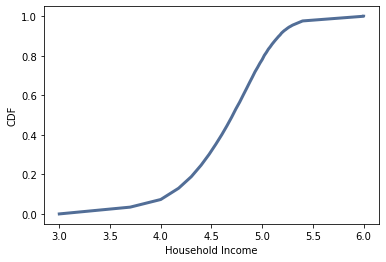

<Figure size 576x432 with 0 Axes>

In [98]:
#The next few plots show the difference between a log_upper of 6 and 7
log_cdf = thinkstats2.Cdf(log_sample)
thinkplot.Cdf(log_cdf)
thinkplot.Show(xlabel='Household Income', ylabel='CDF')

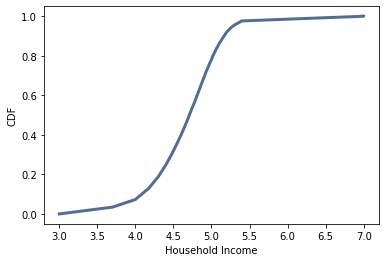

<Figure size 576x432 with 0 Axes>

In [99]:
log_cdf1 = thinkstats2.Cdf(log_sample1)
thinkplot.Cdf(log_cdf1)
thinkplot.Show(xlabel='Household Income', ylabel='CDF')

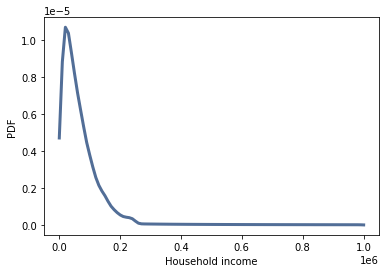

<Figure size 576x432 with 0 Axes>

In [100]:
pdf = thinkstats2.EstimatedPdf(sample)
thinkplot.Pdf(pdf)
thinkplot.Show(xlabel='Household income', ylabel='PDF')

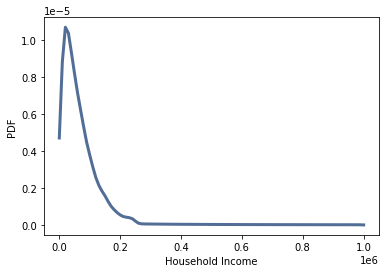

<Figure size 576x432 with 0 Axes>

In [101]:
pdf1 = thinkstats2.EstimatedPdf(sample1)
thinkplot.Pdf(pdf)
thinkplot.Show(xlabel='Household Income', ylabel='PDF')

Sample mean: 74278.70753118739
Sample median: 51226.45447894046

Sample 1 mean: 124267.39722164693
Sample 1 median: 51226.45447894046
Roughly 66% of households make less than the mean.
The upper bound affects results by increasing the moment-based skewness.
Since the upper bound of 1 million is not correct and we lack the information for the higher incomes
We can't accurately make predictions for the skewness.


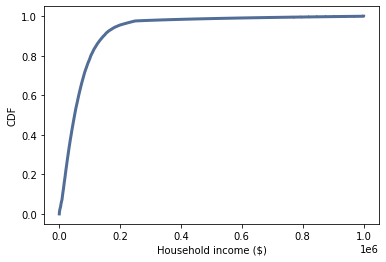

In [102]:
"""
With a higher upper bound, we can see a change in the sample skewness from 4.94 to 11.60. 
The standard deviation also increases significantly from 93946 to 559608. 
However Pearson's skewness decreases from .73 to .39. 

The solution file mentions that this is because the sd is raised two the third power as a denominator.
I'll take the author's word for it. 

I've gone ahead and recalculated the mean and median based on the information in the ipynb file
even though I already completed it using the density.Summarize function above. 

I'm really trying to understand this better. I got confused when calculating the fraction of households
with income below the mean. I knew I needed to use a CDF to calculate it, but was unsure how to go about this.

That is why I recalculated everything based on the ipynb file, upon recalculating, I realized that this is 
the statistic with cdf[mean].





"""
def RawMoment(xs, k):
    return sum(x**k for x in xs) / len(xs)

def Mean(xs):
    return RawMoment(xs, 1)

def Median(xs):
    cdf = thinkstats2.Cdf(xs)
    return cdf.Value(0.5)


s_mean = Mean(sample)
s1_mean = Mean(sample1)

s_med = Median(sample)
s1_med = Median(sample1)

print(f"Sample mean: {s_mean}")
print(f"Sample median: {s_med}")

print(f"\nSample 1 mean: {s1_mean}")
print(f"Sample 1 median: {s1_med}")



cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Household income ($)', ylabel='CDF')


lt_mean = '{:.0%}'.format(cdf.Prob(Mean(sample)))
print(f"Roughly {lt_mean} of households make less than the mean.")

print("The upper bound affects results by increasing the moment-based skewness.")
print("Since the upper bound of 1 million is not correct and we lack the information for the higher incomes")
print("We can't accurately make predictions for the skewness.")
